In [2]:
import Pkg; Pkg.activate("..")
import QuadGK
using Distributions, Zygote, JuMP, Ipopt, NLopt, BSplines

include("util.jl")

# want to plot in R
using RCall
@rlibrary ggplot2
R"
suppressPackageStartupMessages({
library(tidyverse)
library(patchwork)
})
";

 Activating environment at `~/workspace/unplanned-sample-size-adaptation/Project.toml`


In [3]:
    α = 0.025; β = 0.2
 crit = quantile(Normal(), 1 - α)
  θ_1 = 0.4; τ = 0.2
prior = truncated(Normal(θ_1, τ), -0.5, 1)
 φ(θ) = pdf(prior, θ)
    n = 79.0; m = 26.0;

In [4]:
# parameterise the shape as bspline, should be more stable than global polynomial
function f(z, a, b, coefs) 
    @assert length(coefs) == 4 "coefs must be of length 4"
    Spline(BSplineBasis(4, range(a, b; length = 2)), coefs)(z)
end;

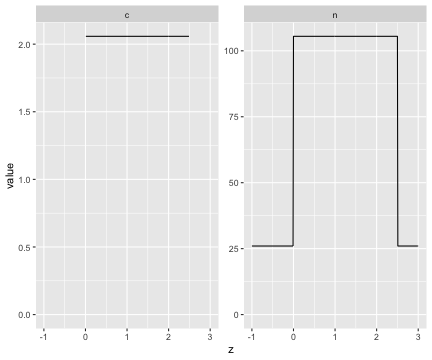

RObject{VecSxp}


In [5]:
function samplesize(z, n1, cfut, ceff, β...)
    f(z, cfut, ceff, [β[i] for i in 1:length(β)]) .+ n1
end

function criticalvalue(z, cfut, ceff, β...)
    z <= cfut ? (return  1e9) : nothing
    z >= ceff ? (return -1e9) : nothing
    f(z, cfut, ceff, [β[i] for i in 1:length(β)])
end

 β_n_start = 1.5*(n - m) .* ones(4)
 β_c_start = 1.05*crit .* ones(4)
cfut_start, ceff_start = 0, 2.5
n1_start = m

 z = collect(-1:0.01:3)
n_ = samplesize.(z, n1_start, cfut_start, ceff_start, β_n_start...)
c_ = criticalvalue.(z, cfut_start, ceff_start, β_c_start...)
R"
tibble(
    z = $z,
    n = $n_,
    c = $c_ %>% if_else(abs(.) <10, ., NA_real_)
) %>%
pivot_longer(-z, names_to = 'type', values_to = 'value') %>%
filter(complete.cases(value)) %>% 
ggplot() +
    aes(z, value) +
    geom_line() +
    scale_y_continuous(limits = c(0, NA)) +
    facet_wrap(~type, scales = 'free_y')
"

In [19]:
ξ2, ω2 = QuadGK.gauss(10)

([-0.9739065285171717, -0.8650633666889845, -0.6794095682990244, -0.4333953941292472, -0.14887433898163124, 0.14887433898163124, 0.4333953941292472, 0.6794095682990244, 0.8650633666889845, 0.9739065285171717], [0.06667134430868811, 0.14945134915058064, 0.2190863625159821, 0.26926671930999635, 0.29552422471475276, 0.29552422471475276, 0.26926671930999635, 0.2190863625159821, 0.14945134915058064, 0.06667134430868811])

In [20]:
function ess(n1, cfut, ceff, β_n...)
    futility = n1 * (1 - integrate(z -> marginal_pdf.(z, n1, φ), cfut))
    efficacy = n1 * integrate(z -> marginal_pdf.(z, n1, φ), ceff)
    stagetwo = integrate(z -> samplesize(z, n1, cfut, ceff, β_n...) * marginal_pdf.(z, n1, φ), cfut, ceff; ξ = ξ2, ω = ω2)
    futility + stagetwo + efficacy
end

@show ess(n1_start, cfut_start, ceff_start, β_n_start...);

ess(n1_start, cfut_start, ceff_start, β_n_start...) = 69.7649556616258


In [21]:
function mtoer(n1, cfut, ceff, coefs...) 
    β_n = coefs[1:4]
    β_c = coefs[5:8]
    stagetwo = integrate(
        z -> CP(z, samplesize(z, n1, cfut, ceff, β_n...), n1, criticalvalue(z, cfut, ceff, β_c...), 0) * pdf(Normal(), z),
        cfut, ceff; 
        ξ = ξ2, ω = ω2
    )
    efficacy = 1 - cdf(Normal(), ceff)
    stagetwo + efficacy
end

β_combined_start = vcat(β_n_start, β_c_start)

@show mtoer(n1_start, cfut_start, ceff_start, β_combined_start...);

mtoer(n1_start, cfut_start, ceff_start, β_combined_start...) = 0.022883711809150945


In [22]:
function ep(n1, cfut, ceff, coefs...) 
    β_n = coefs[1:4]
    β_c = coefs[5:8]
    stagetwo = integrate(
        z -> PP(z, samplesize(z, n1, cfut, ceff, β_n...), n1, criticalvalue(z, cfut, ceff, β_c...), φ) * cmarginal_pdf(z, n1, φ),
        cfut, ceff; 
        ξ = ξ2, ω = ω2
    )
    efficacy = integrate(z -> cmarginal_pdf(z, n1, φ), ceff)
    stagetwo + efficacy
end

@show ep(n1_start, cfut_start, ceff_start, β_combined_start...);

ep(n1_start, cfut_start, ceff_start, β_combined_start...) = 0.8216545302337381


In [23]:
mdl = Model(
    optimizer_with_attributes(
        Ipopt.Optimizer, 
        "print_level" => 4,
        #"nlp_scaling_method" => "gradient-based",
        #"nlp_scaling_max_gradient" => 100.0,
        #"nlp_scaling_min_value" => 1e-3,
        "tol" => 1e-6,
        "max_cpu_time" => 30.0, # seconds
        "max_iter" => 10000
    )
)

#register(mdl, :samplesize, 4 + kn + 1, samplesize; autodiff = true)
#register(mdl, :criticalvalue, 4 + kc + 1, criticalvalue; autodiff = true)
register(mdl, :ess,   3 + 4,       ess; autodiff = true)
register(mdl, :mtoer, 3 + 4 + 4, mtoer; autodiff = true)
register(mdl, :ep,    3 + 4 + 4,    ep; autodiff = true)

@variable(mdl, 
    0 <= β_n[i=1:4] <= 5*n, 
    start = β_n_start[i]
)
@variable(mdl, 
    0 <= β_c[i=1:4] <= 5, 
    start = β_c_start[i]
)
@constraint(mdl, [i = 1:3], β_c[i] == β_c[i+1])
@expression(mdl, coefs, vcat(β_n, β_c))
@variable(mdl, 
    1 <= n1 <= 0.66*n,
    start = m
)
@variable(mdl, 
    -3 <= cfut <= crit/2, 
    start = cfut_start
)
# fix(cfut, cfut_start; force = true)
@variable(mdl, 
    crit/2 <= ceff <= 3, 
    start = ceff_start
)
# fix(ceff, ceff_start; force = true)
@constraint(mdl, ceff - cfut >= 0.5)

@NLobjective(mdl, Min, ess(n1_start,cfut, ceff, β_n...))
@NLconstraint(mdl, mtoer(n1_start, cfut, ceff, coefs...) <= 0.025)
@NLconstraint(mdl, ep(n1_start, cfut, ceff, coefs...) >= 0.8)
#@NLconstraint(mdl, samplesize(0 + .1, 0, 3, m, β_n...) >= m + 5)
#@NLconstraint(mdl, samplesize(3 - .1, 0, 3, m, β_n...) >= m + 5)

print(mdl)

Min ess(26.0, cfut, ceff, β_n[1], β_n[2], β_n[3], β_n[4])
Subject to
 β_c[1] - β_c[2] = 0.0
 β_c[2] - β_c[3] = 0.0
 β_c[3] - β_c[4] = 0.0
 ceff - cfut ≥ 0.5
 β_n[1] ≥ 0.0
 β_n[2] ≥ 0.0
 β_n[3] ≥ 0.0
 β_n[4] ≥ 0.0
 β_c[1] ≥ 0.0
 β_c[2] ≥ 0.0
 β_c[3] ≥ 0.0
 β_c[4] ≥ 0.0
 n1 ≥ 1.0
 cfut ≥ -3.0
 ceff ≥ 0.9799819922700288
 β_n[1] ≤ 395.0
 β_n[2] ≤ 395.0
 β_n[3] ≤ 395.0
 β_n[4] ≤ 395.0
 β_c[1] ≤ 5.0
 β_c[2] ≤ 5.0
 β_c[3] ≤ 5.0
 β_c[4] ≤ 5.0
 n1 ≤ 52.14
 cfut ≤ 0.9799819922700288
 ceff ≤ 3.0
 mtoer(26.0, cfut, ceff, β_n[1], β_n[2], β_n[3], β_n[4], β_c[1], β_c[2], β_c[3], β_c[4]) - 0.025 ≤ 0
 ep(26.0, cfut, ceff, β_n[1], β_n[2], β_n[3], β_n[4], β_c[1], β_c[2], β_c[3], β_c[4]) - 0.8 ≥ 0


In [24]:
JuMP.optimize!(mdl)

Total number of variables............................:       11
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       11
                     variables with only upper bounds:        0
Total number of equality constraints.................:        3
Total number of inequality constraints...............:        3
        inequality constraints with only lower bounds:        2
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        1


Number of Iterations....: 561

                                   (scaled)                 (unscaled)
Objective...............:   5.6958963579217823e+01    5.6958963579217823e+01
Dual infeasibility......:   1.0287420929738119e+01    1.0287420929738119e+01
Constraint violation....:   1.3093033713844019e-03    1.3093033713844019e-03
Complementarity.........:   1.1259358553875011e-01    1.1259358553875011e-01
Overall NLP 

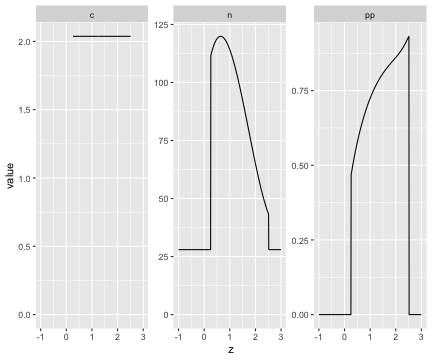

RObject{VecSxp}


In [25]:
  z = collect(-1:0.01:3)
 n_ = samplesize.(z, value(n1), value(cfut), value(ceff), value.(β_n)...)
 c_ = criticalvalue.(z, value(cfut), value(ceff), value.(β_c)...)
pp_ = PP.(z, n_, value(n1), c_, φ)
R"
tibble(
     z = $z,
     n = $n_,
     c = $c_ %>% if_else(abs(.) <10, ., NA_real_),
    pp = $pp_
) %>%
pivot_longer(-z, names_to = 'type', values_to = 'value') %>%
filter(complete.cases(value)) %>% 
ggplot() +
    aes(z, value) +
    geom_line() +
    scale_y_continuous(limits = c(0, NA)) +
    facet_wrap(~type, scales = 'free_y')
"

In [26]:
@show ess(value(n1), value(cfut), value.(ceff), value.(β_n)...);
@show mtoer(value(n1), value(cfut), value(ceff), value.(coefs)...);
@show ep(value(n1), value(cfut), value(ceff), value.(coefs)...);

ess(value(n1), value(cfut), value.(ceff), value.(β_n)...) = 57.717078603576695
mtoer(value(n1), value(cfut), value(ceff), value.(coefs)...) = 0.02553235857456678
ep(value(n1), value(cfut), value(ceff), value.(coefs)...) = 0.8048629620731923


In [ ]:
value(n1), value(cfut), value.(ceff), value.(β_n)